In [1]:
"""
Find the SWOT satellite fly-by time through a bounding box. 
The time will have uncertainty of tens of seconds to minutes depending on 
the size of the bounding box.

Make sure download the two shapefile associated with the SWOT orbit data from the aviso website. You can use the included script to download the data.

    bash download_swot_orbit.sh

Usage:
    python find_swot_passes_science.py -sw_corner -130.0 35.0 -ne_corner -125.0 40.0 -output_filename /tmp/test.png

Author: Jinbo Wang
Date: 2021-07-21
"""

import geopandas as gpd
import pandas as pd
import shapely.geometry as sgeometry
from datetime import timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, LineString, Point
import numpy as np
import os,argparse

In [2]:
#download the two shapefile associated with the SWOT orbit data from the aviso website
if os.path.exists("../orbit_data/sph_science_nadir.zip") is False or os.path.exists("../orbit_data/sph_science_swath.zip") is False:
    print("Please download the two shapefiles associated with the SWOT orbit data from the aviso website using the included script.\n")
    print("run bash download script using:")
    print("bash download_swot_orbit_data.sh\n")
    exit()


In [3]:
def find_time(ID_PASS_value, extended_bbox):
    
    """
    Find the index of the first point in the combined LineString (for the given ID_PASS) 
    that intersects with the extended bounding box.

    Parameters:
    - ID_PASS_value (int): The ID_PASS value for which to find the intersecting point.
    - extended_bbox (Polygon): The extended bounding box to check intersection.

    Returns:
    - int or None: Index of the first intersecting point, or None if no intersection is found.
    """
    nadir_data = gpd.read_file("../orbit_data/sph_science_nadir.zip")

    def join_linestrings(group):
        """Join LineStrings in the order they appear in the file."""
        if len(group) == 1:
            return group.iloc[0].geometry
        else:
            # Combine LineStrings
            return LineString([pt for line in group.geometry for pt in line.coords])

    def index_of_first_point_inside_bbox(line, bbox):
        """Returns the index of the first point of the LineString that falls inside the bounding box."""
        for index, point in enumerate(line.coords):
            if bbox.contains(Point(point)):
                return index
        return 0 # If no point falls inside the bounding box
    
    # Filtering the GeoDataFrame for rows with the given ID_PASS_value
    subset_gdf = nadir_data[nadir_data["ID_PASS"] == ID_PASS_value]
    
    # Joining LineStrings if there are multiple rows with the same ID_PASS
    combined_geometry = join_linestrings(subset_gdf)
    
    # Finding the index of the first point inside the extended bounding box
    index = index_of_first_point_inside_bbox(combined_geometry, extended_bbox)

    time_str=subset_gdf['START_TIME'].iloc[0]
    _, day_num, time_str = time_str.split(" ", 2)
    days = int(day_num)
    time_parts = list(map(int, time_str.split(":")))
    delta = timedelta(days=days-1, hours=time_parts[0], minutes=time_parts[1], seconds=time_parts[2]+index*30) 
    return delta+pd.Timestamp("2023-07-21T05:33:45.768") 


def plotit(index, ax, row):
    print(index)
    # Set the extent of the map
    ax.set_extent([sw_corner[0], ne_corner[0], sw_corner[1], ne_corner[1]])  # Set extent based on your data's region

    # Add high-resolution coastline
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')
    # Plot the shapefile data
    #gdf.plot(ax=ax, transform=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable longitude labels at the top
    gl.right_labels = False  # Disable latitude labels on the right

    # Plot the overlapping segments with light green color
    overlapping_segments.loc[[index]].plot(ax=ax, edgecolor="blue", facecolor="lightgreen")
    ax.set_title(f"Pass: {row['ID_PASS']}")
    
    # Annotate with cycle, pass number, and the four lines of date and time
    #annotation_text = f"Time 0: {row['TIME_0'].strftime('%Y-%m-%d %H:%M:%S')}\n" \
    #                  f"Time 1: {row['TIME_1'].strftime('%Y-%m-%d %H:%M:%S')}\n" \
    #                  f"Time 2: {row['TIME_2'].strftime('%Y-%m-%d %H:%M:%S')}\n" \
    #                  f"Time 3: {row['TIME_3'].strftime('%Y-%m-%d %H:%M:%S')}"
    
    #ax.annotate(annotation_text, xy=(0.05, 0.1), xycoords='axes fraction', backgroundcolor='white')


In [19]:
# Define domain
# Global
sw_corner = [-180.0, -90.0]
ne_corner = [180.0, 90.0]

# West Greenland
wg_sw_corner = [-56.55, 68.32]
wg_ne_corner = [-50., 72.5]
# East Greenland
eg_sw_corner = [-30, 65]
eg_ne_corner = [-17., 80]
# Hawaii
sw_corner = [-167, 0.0]
ne_corner = [-135.0, 45.0]

lat_lims = [sw_corner[1],ne_corner[1]]

# Load the shapefile
gdf_karin = gpd.read_file("../orbit_data/sph_calval_swath.zip")

bbox = geometry.box(sw_corner[0], sw_corner[1], ne_corner[0], ne_corner[1])
overlapping_segments = gdf_karin[gdf_karin.intersects(bbox)]
extended_bbox = box(bbox.bounds[0] - 0.2, bbox.bounds[1] - 0.2, bbox.bounds[2] + 0.2, bbox.bounds[3] + 0.2) #for nadir data


#gdf_karin = gpd.read_file("../orbit_data/sph_science_swath.zip")
# define the bounding box
wg_bbox_west = geometry.box(wg_sw_corner[0], wg_sw_corner[1], wg_ne_corner[0], wg_ne_corner[1])
eg_bbox_west = geometry.box(eg_sw_corner[0], eg_sw_corner[1], eg_ne_corner[0], eg_ne_corner[1])

# extend the bounding box by 0.2 degree
wg_extended_bbox = box(wg_bbox_west.bounds[0] - 0.2, wg_bbox_west.bounds[1] - 0.2, wg_bbox_west.bounds[2] + 0.2, wg_bbox_west.bounds[3] + 0.2) #for nadir data
eg_extended_bbox = box(eg_bbox_west.bounds[0] - 0.2, eg_bbox_west.bounds[1] - 0.2, eg_bbox_west.bounds[2] + 0.2, eg_bbox_west.bounds[3] + 0.2) #for nadir data

# Filter the GeoDataFrame for rows that intersect with the extended bounding box
wg_overlapping_segments = gdf_karin[gdf_karin.intersects(wg_extended_bbox)]
eg_overlapping_segments = gdf_karin[gdf_karin.intersects(eg_extended_bbox)]



/ext3/miniforge3/envs/swot_python12/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /vsizip/../orbit_data/sph_calval_swath.zip/swot_calval_orbit_june2015-v2_swath.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


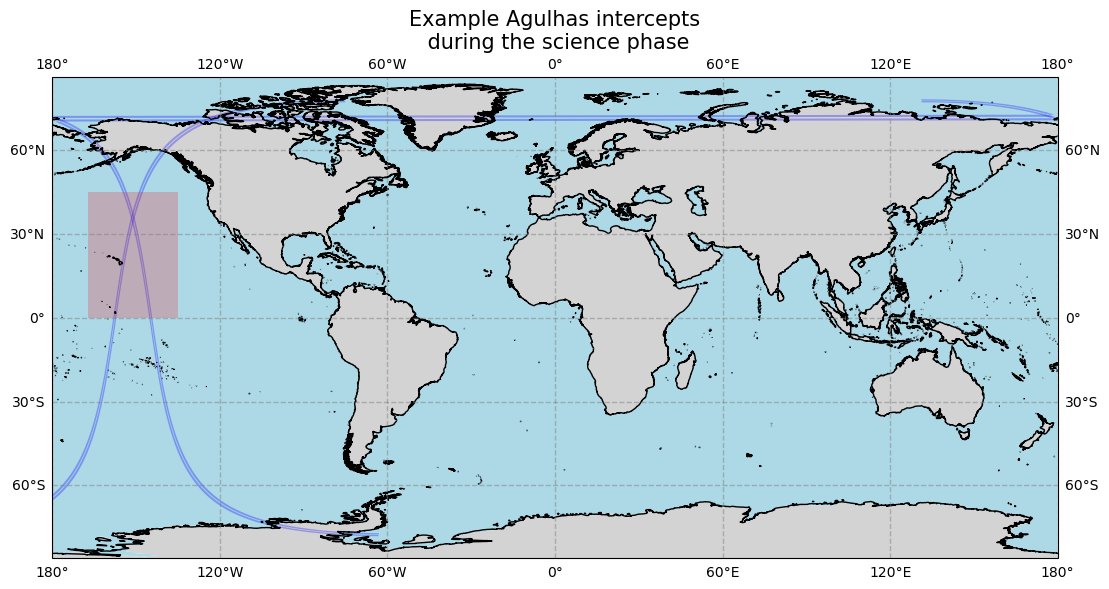

In [20]:
# Set up plot
subplot_kw = {'projection': ccrs.PlateCarree()}

fig, axs = plt.subplots(1,1,figsize=(50,6),subplot_kw=subplot_kw)

axs.set_title("Example Agulhas intercepts\n during the science phase",fontsize=15)

axs.add_feature(cfeature.COASTLINE.with_scale('10m'))
axs.add_feature(cfeature.LAND, edgecolor='none', facecolor='lightgray')
axs.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')
# Plot the shapefile data
#gdf.plot(ax=ax, transform=ccrs.PlateCarree())
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                linewidth=1, color='gray', alpha=0.5, linestyle='--')

overlapping_segments.plot(ax=axs,alpha=0.3,color="b")

b = gpd.GeoSeries(extended_bbox)
b.plot(ax=axs,color="r",alpha=0.2)


#axs.set_extent([-65, -10, 55, 90], crs=ccrs.PlateCarree())

plt.tight_layout()

plt.show()
plt.close()

